In [ ]:
import numpy as np # Linear Algebra
import matplotlib.pyplot as plt # Plotting
from matplotlib.patches import Rectangle, Circle # for visualizing the robot and landmarks

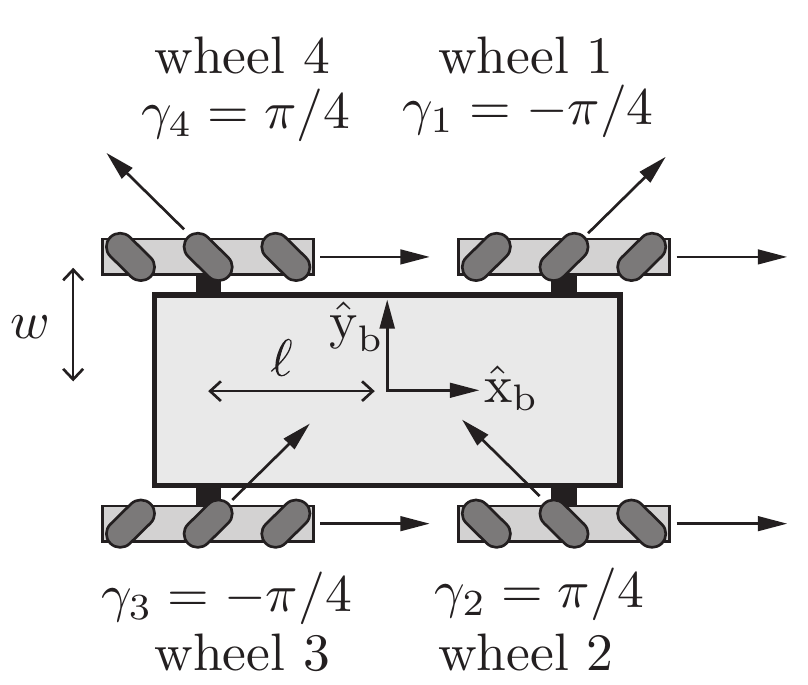

In [ ]:
# position of wheels in body frame
w = 0.2
l = 0.5
positions = [(l, w), (l, -w), (-l, -w), (-l, w)]

# angles of "free-sliding"
gammas = [-np.pi/4., np.pi/4., -np.pi/4., np.pi/4.]
# rotation of direction!
betas = [0., 0., 0., 0.]

wheel_radius = 0.1

In [ ]:
def compute_H(theta, positions, gammas, betas, wheel_radius):
    m = len(positions) # number of wheels
    h_all = np.zeros((m, 3))
    for i in range(m):
        prefix = 1. / (wheel_radius * np.cos(gammas[i]))
        x_i, y_i = positions[i]
        s1 = np.sin(betas[i] + gammas[i])
        c1 = np.cos(betas[i] + gammas[i])
        s2 = np.sin(betas[i] + gammas[i] + theta)
        c2 = np.cos(betas[i] + gammas[i] + theta)
        h_all[i, :] = prefix * np.array([[x_i * s1 - y_i * c1, c2, s2]])
    return h_all

In [ ]:
# A few helpers
def angle_dist(b, a):
    theta = b - a
    while theta < -np.pi:
        theta += 2. * np.pi
    while theta > np.pi:
        theta -= 2. * np.pi
    return theta

In [ ]:
# Let's first create a map!

# We have several landmarks!
landmarks = [(4., 4.), (4., 0.), (4., -4.), (0., -4.), (-4., -4.), (-4., 0.), (-4., 4.), (0., 4.)]
colors = ['red', 'blue', 'green', 'yellow', 'magenta', 'black', 'purple', 'orange']

# Let's plot them!
fig = plt.figure()
ax = fig.add_subplot(111)

def rot(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

first = True
for k in range(len(landmarks)):
    rect = Circle(landmarks[k], 0.5, edgecolor = colors[k], fill=False, label="landmark" if first else None)
    # add rectangle to plot
    ax.add_patch(rect)
    ax.annotate(str(k+1), xy=landmarks[k], fontsize=20, ha="center", va="center")
    first = False

# ax.legend()
# Set the limits for the environment
plt.xlim(-5, 5);
plt.ylim(-5, 5);

In [ ]:
# We assume that the robot is equiped with a lidar
#   the lidar has a pi/4. width centered in the heading of the robot

# Let's create a function that given the pose of the robot, return the hits of the lidar rays
def lidar(x, landmarks, width = np.pi / 4.):
    detects = []

    theta = x[0, 0] # heading of the robot
    for k in range(len(landmarks)):
        xx = landmarks[k][0] - x[1, 0]
        yy = landmarks[k][1] - x[2, 0]
        rel = np.arctan2(yy, xx)
        rel = angle_dist(rel, theta)
        if rel >= -width/2. and rel <= width/2.:
            r = np.sqrt(xx**2 + yy**2)
            detects += [(r, rel, k + 1)] # (distance, angle difference, identity)
    return detects

In [ ]:
p = np.zeros((3, 1))
p[0, 0] = 0. # play with the theta to see what we are getting!

print(lidar(p, landmarks))

In [ ]:
# Let's do a small simulation
p = np.zeros((3, 1)) # position and theta of the base (θ, x, y)
# p[1, 0] = -3.
# p[2, 0] = 3.

# timestep
dt = 0.1

all_poses = [np.copy(p)]
max_steps = 4000
step = 0
while True: # run for a bit
    # u = np.array([[0.5, 0.5, 0.5, 0.5]]).T
    u = np.array([[0.5, 0., -0.5, 0.]]).T # wheel commands that do a circle!!
    if step % 2 == 0:
        u = np.random.randn(4, 1)
    H = compute_H(p[0, 0], positions, gammas, betas, wheel_radius) # get current H
    v = np.linalg.pinv(H) @ u
    p = p + v * dt

    # Just for visuals
    all_poses += [p]

    step += 1
    if step >= max_steps:
        break

In [ ]:
# Plot the trajectory
fig = plt.figure()
ax = fig.add_subplot(111)

def rot(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

first = True
for k in range(len(landmarks)):
    rect = Circle(landmarks[k], 0.5, edgecolor = colors[k], fill=False, label="landmark" if first else None)
    # add rectangle to plot
    ax.add_patch(rect)
    ax.annotate(str(k+1), xy=landmarks[k], fontsize=20, ha="center", va="center")
    first = False

def rot(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

first = True
for p in all_poses[::40]:
    # compute positions
    bpb = np.array([[-l, -w]]).T
    bpw = rot(p[0, 0]) @ bpb + p[1:, :]

    rect = Rectangle((bpw[0, 0], bpw[1, 0]), 2*l, 2*w, edgecolor = 'black', fill=False, angle=p[0, 0] * 180. / np.pi, label="robot" if first else None)
    # add rectangle to plot
    ax.add_patch(rect)
    first = False

    detects = lidar(p, landmarks)
    for d in detects:
        ax.plot([p[1, 0], landmarks[d[2]-1][0]], [p[2, 0], landmarks[d[2]-1][1]], color=colors[d[2]-1])

# ax.legend()
# Set the limits for the environment
plt.xlim(-5, 5);
plt.ylim(-5, 5);